In [ ]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load the datasets
fake_news_df = pd.read_csv("/content/drive/MyDrive/Misinformation_Detection/Fake.csv")
true_news_df = pd.read_csv("/content/drive/MyDrive/Misinformation_Detection/True.csv")

In [ ]:
fake_news_df['label'] = 1  # Fake news label
true_news_df['label'] = 0  # True news label

In [ ]:
merged_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)

**Data Cleaning**

In [ ]:
merged_df.to_csv("merged_news_dataset.csv", index=False)
merged_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [ ]:
# Check for missing values
print(merged_df.isnull().sum())
# Inspect unique labels
print(merged_df['label'].unique())


title      0
text       0
subject    0
date       0
label      0
dtype: int64
[1 0]


In [ ]:
pip install nltk

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

merged_df['cleaned_text'] = merged_df['text'].apply(clean_text)

In [ ]:
merged_df.head()

,title,text,subject,date,label,cleaned_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump wish americans happy new year lea...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,friday revealed former milwaukee sheriff david...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,christmas day donald trump announced would bac...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis used annual christmas day message...


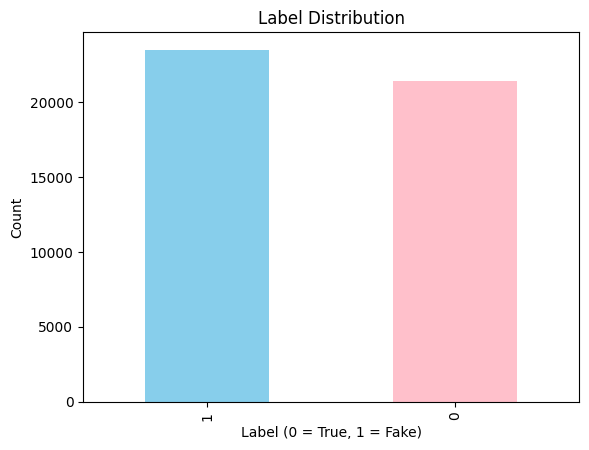

In [ ]:
# Plot label distribution
merged_df['label'].value_counts().plot(kind='bar', color=['skyblue', 'Pink'], title='Label Distribution')
plt.xlabel('Label (0 = True, 1 = Fake)')
plt.ylabel('Count')
plt.show()

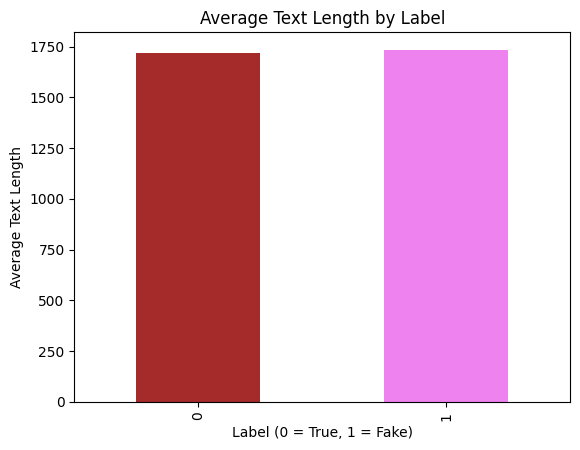

In [ ]:
merged_df['text_length'] = merged_df['cleaned_text'].apply(len)
avg_text_length = merged_df.groupby('label')['text_length'].mean()

avg_text_length.plot(kind='bar', color=['Brown', 'Violet'], title='Average Text Length by Label')
plt.xlabel('Label (0 = True, 1 = Fake)')
plt.ylabel('Average Text Length')
plt.show()

In [ ]:
# Split text into words for each category
fake_words = ' '.join(merged_df[merged_df['label'] == 1]['cleaned_text']).split()
true_words = ' '.join(merged_df[merged_df['label'] == 0]['cleaned_text']).split()

# Most common words
fake_word_counts = Counter(fake_words).most_common(10)
true_word_counts = Counter(true_words).most_common(10)

print("Most Common Words in Fake News:", fake_word_counts)
print("Most Common Words in True News:", true_word_counts)

Most Common Words in Fake News: [('trump', 73793), ('said', 31016), ('people', 25929), ('president', 25556), ('would', 23416), ('one', 22931), ('us', 22004), ('clinton', 17973), ('obama', 17772), ('like', 17611)]
Most Common Words in True News: [('said', 99040), ('trump', 42599), ('us', 41147), ('would', 31520), ('reuters', 28404), ('president', 25547), ('state', 18756), ('government', 17981), ('states', 17636), ('new', 16786)]


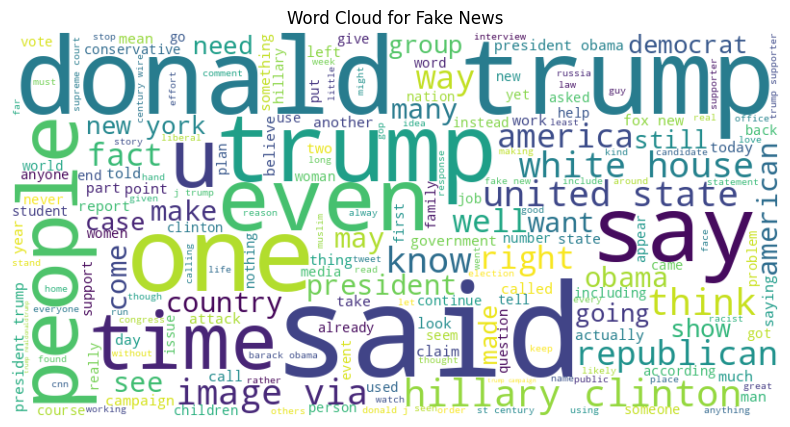

In [ ]:
fake_text = ' '.join(merged_df[merged_df['label'] == 1]['cleaned_text'])
true_text = ' '.join(merged_df[merged_df['label'] == 0]['cleaned_text'])

# Generate word clouds
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
true_wc = WordCloud(width=800, height=400, background_color='white').generate(true_text)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')
plt.show()

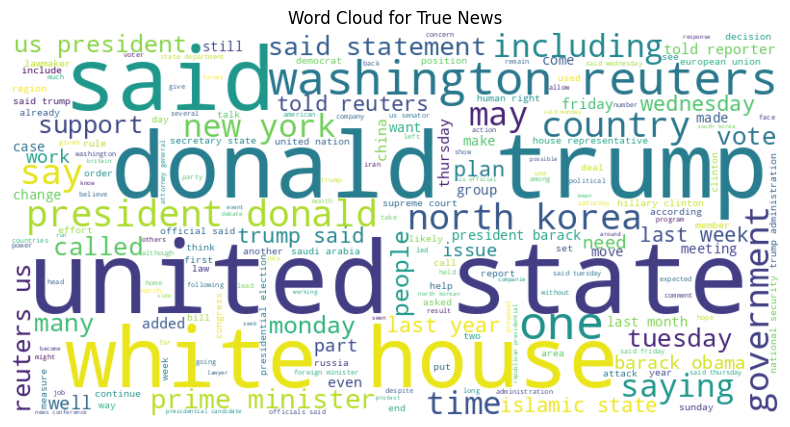

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(true_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News')
plt.show()

**Feature Engineering**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size to top 5000 words
    ngram_range=(1, 2),  # Use unigrams and bigrams
    stop_words='english'  # Remove stop words
)

# Fit and transform the cleaned text
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['cleaned_text'])

# Get feature names (vocabulary)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# Display the shape of the resulting TF-IDF matrix and a sample
tfidf_matrix_shape = tfidf_matrix.shape
sample_tfidf = tfidf_matrix[0]

tfidf_matrix_shape, sample_tfidf

((44898, 5000),
 <1x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 97 stored elements in Compressed Sparse Row format>)

**Traning the Mode**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the features (TF-IDF matrix) and labels
X = tfidf_matrix  # Features from TF-IDF
y = merged_df['label']  # Labels (0 for fake, 1 for true)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Train the model on the training set
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99


In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 0.9977728285077951


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

from imblearn.combine import SMOTEENN

# Apply SMOTE + ENN (Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/di

In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 0.9977728285077951


In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting (XGBoost) Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Gradient Boosting (XGBoost) Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 0.9977728285077951


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Predictions for Gradient Boosting
y_pred_gb = xgb_model.predict(X_test)
print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_gb))

# Predictions for Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

ROC-AUC: 0.9978267305525468
Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

ROC-AUC: 0.9978509083927999


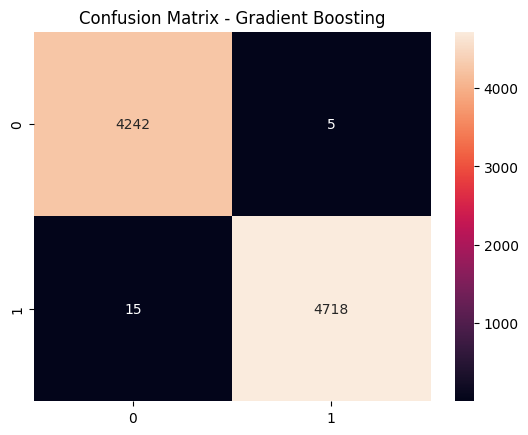

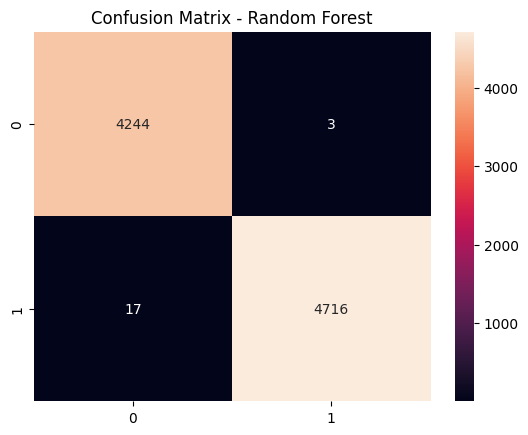

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gradient Boosting Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

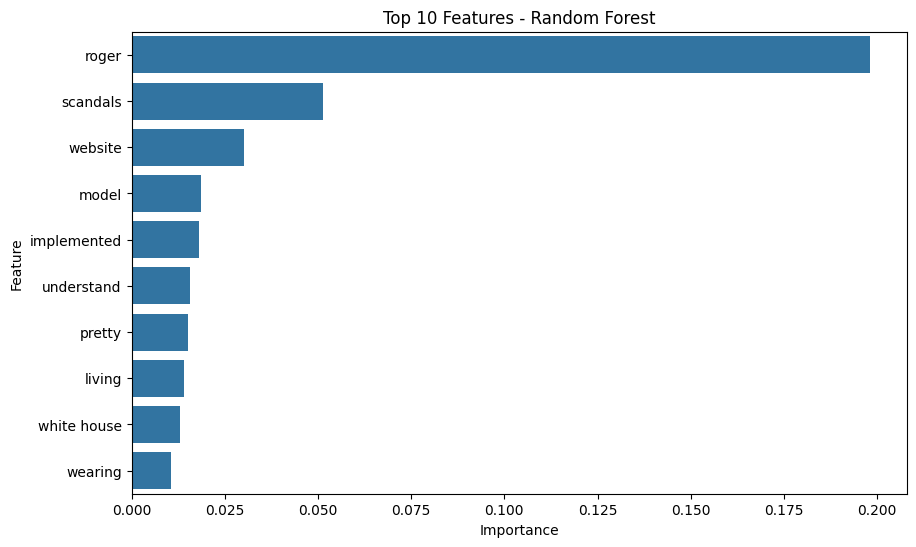

In [ ]:
# Extract feature names from the TF-IDF vectorizer
features = tfidf.get_feature_names_out()

# Get feature importance from the Random Forest model
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 10 Features - Random Forest")
plt.show()